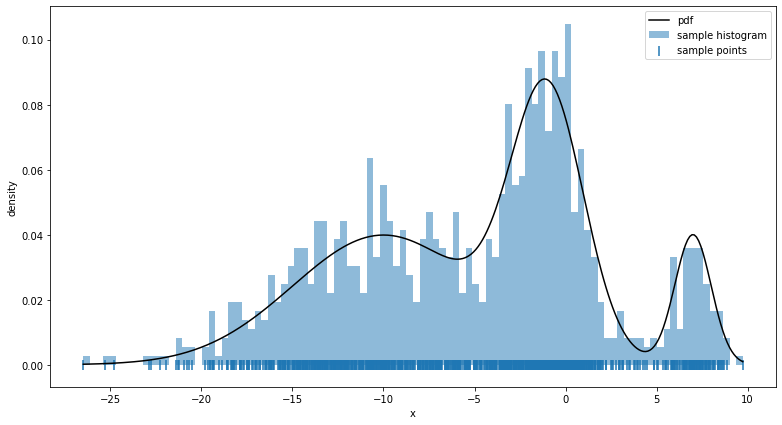

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from util.expectiles import tauspace, expectile
from util.gmm import EXAMPLE
SAMPLE, GMM_X, GMM_Y = EXAMPLE()

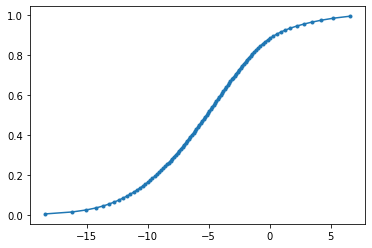

In [2]:
asyms = tauspace(101)
expts = expectile(SAMPLE, asyms)
plt.plot(expts, asyms, marker=".")
plt.show()

In [16]:
def setup_plot(sample=SAMPLE, x=GMM_X, f=GMM_Y):
    dx = x[1] - x[0]
    F = np.cumsum(f)*dx
    t = np.linspace(0.001, 0.999, 333)
    e = expectile(sample, t)
    g = np.gradient(e, t, edge_order=2)
    fig, ax = plt.subplots(2, 2, figsize=(14, 8))
    ax[0,0].plot(e, t, color="black", alpha=0.5)
    ax[0,0].set_xlabel("expectile")
    ax[0,0].set_ylabel("asymmetry")
    ax[0,0].set_ylim([-0.1, 1.1])
    ax[0,1].plot(g, t, color="black", alpha=0.5)
    ax[0,1].set_xlabel("expectile derivative")
    ax[0,1].set_ylabel("asymmetry")
    ax[0,1].set_xscale('log')
    ax[0,1].set_ylim([-0.1, 1.1])
    ax[1,0].plot(x, F, color="black", alpha=0.5)
    ax[1,0].set_xlabel("x")
    ax[1,0].set_ylabel("F(x)")
    ax[1,0].set_ylim([-0.1, 1.1])
    ax[1,1].plot(x, f, color="black", alpha=0.5)
    ax[1,1].hist(sample, bins=100, alpha=0.2, density=True, color="black")
    ax[1,1].set_xlabel("x")
    ax[1,1].set_ylabel("f(x)")
    return ax

def experiment(τ, I, marker='.', **kwargs):
    ε = expectile(SAMPLE, τ)
    I.fit(ε, τ, **kwargs)
    X = I.sample(1000)
    ax = setup_plot()
    plt.gcf().suptitle(f"{τ.size}-tau {I}")
    ax[0,0].plot(ε, τ, marker=marker)
    ax[0,1].plot(I.g, I.τ, marker=marker)
    ax[1,0].plot(I.ε, I.F, marker=marker)
#     ax[1,1].plot(I.ε, I.f, marker=marker)
    ax[1,1].hist(X, bins=50, alpha=0.2, density=True, color="purple")
    plt.show()

In [19]:
class NonImputer:
    def fit(self, ε_, τ_, i=None):
        g_ = np.gradient(ε_, τ_, edge_order=2)
        if i is None: i = ε_.size//2
        self.μ = μ = ε_[i]
        self.ε = ε = np.delete(ε_, i)
        self.τ = τ = np.delete(τ_, i)
        self.g = g = np.delete(g_, i)
        self.N = N = -(ε - μ + τ * g * (1-2*τ))
        self.D = D = g * (1-2*τ)**2
        self.F = F = N / D
        self.f = np.gradient(F, ε, edge_order=1)
        return self
    def sample(self, k):
        dx = np.diff(self.ε)
        dx = 0.5*(np.pad(dx, (1, 0), 'edge') + np.pad(dx, (0, 1), 'edge'))
        p = np.clip(self.f, 1e-7, None) * dx
        p = p / p.sum()
        return np.random.choice(self.ε, k, p=p)
    def __repr__(self):
        return f"NonImputer()"

# There's no need to sample because we can just use the probabilities
# in a weighted update.

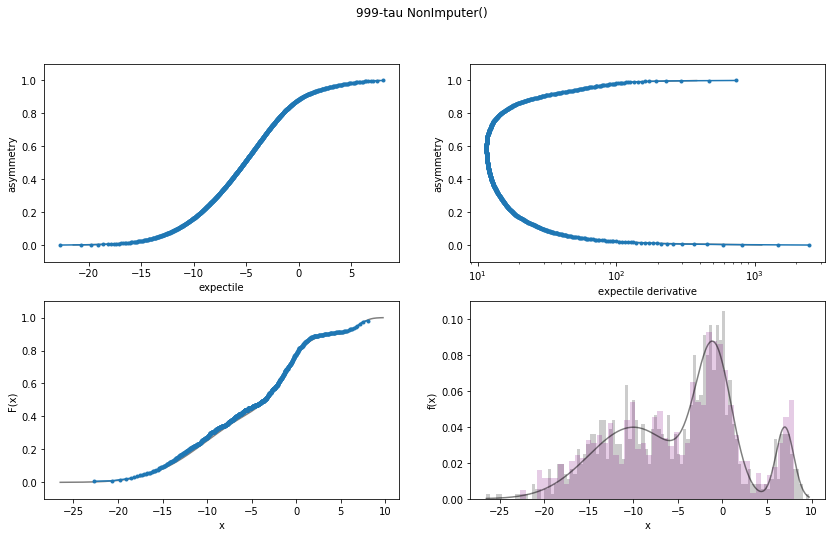

In [18]:
experiment(tauspace(999, edges=False), NonImputer())